# NB03: Component Analysis

**Question:** Which RAG knobs matter most? Optimal values? Interactions?

This notebook analyzes RAG component effects:
- Variance decomposition (which factors explain the most performance variance)
- Marginal effects of each component
- Prompt and top-K deep dives
- Interaction effects between components
- Optimal configurations

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats

from analysis_utils import (
    load_all_results, setup_plotting, identify_bottlenecks,
    compute_marginal_means, plot_component_effects,
    plot_interaction_heatmap, find_synergistic_combinations,
    weighted_mean_with_ci, multi_metric_bottlenecks_df,
    metric_correlation_matrix, facet_by_dataset,
    PRIMARY_METRIC, BROKEN_MODELS,
    MULTI_METRIC_SET, CORRECTNESS_METRICS, CONTEXT_METRICS,
    GROUNDEDNESS_METRICS,
    DATASET_COLORS, DATASET_MARKERS, DATASET_LABELS,
)

setup_plotting()
STUDY_PATH = Path("../outputs/smart_retrieval_slm")

df_all = load_all_results(STUDY_PATH)
df = df_all[~df_all['model_short'].isin(BROKEN_MODELS)].copy()

# Focus on RAG experiments only
rag = df[df['exp_type'] == 'rag'].copy()
print(f"RAG experiments: {len(rag)} (from {len(df)} total, {len(df_all)} before broken-model filter)")

# Check which metrics have data
available_metrics = [m for m in MULTI_METRIC_SET if m in rag.columns and rag[m].notna().sum() >= 10]
print(f"\nMetrics with sufficient data for multi-metric analysis:")
for m in available_metrics:
    n = rag[m].notna().sum()
    print(f"  {m:<20s}: {n:>4d}/{len(rag)} ({n/len(rag)*100:.0f}%)")

# Context-aware metric availability flags (used across multiple sections)
has_faith = 'faithfulness' in rag.columns and rag['faithfulness'].notna().sum() >= 10
has_halluc = 'hallucination' in rag.columns and rag['hallucination'].notna().sum() >= 10
has_ctx_recall = 'context_recall' in rag.columns and rag['context_recall'].notna().sum() >= 10
has_aic = 'answer_in_context' in rag.columns and rag['answer_in_context'].notna().sum() >= 10


  343 experiment(s) use configs outside the current YAML.
  Consider adding these to your study config to explore them:
    • model: 42 exps — Phi-3-mini
    • query_transform: 314 exps — iterative
  Deduplicated: dropped 241 duplicate experiments (same effective config, kept best F1)
RAG experiments: 668 (from 710 total, 749 before broken-model filter)

Metrics with sufficient data for multi-metric analysis:
  f1                  :  668/668 (100%)
  exact_match         :  668/668 (100%)
  bertscore_f1        :   50/668 (7%)
  faithfulness        :   14/668 (2%)
  answer_in_context   :  662/668 (99%)
  context_recall      :  662/668 (99%)


## 1. Variance Decomposition

The single most important thesis figure: which factors explain the most F1 variance?

Variance Explained by Factor (%)
  model_short         :  60.7%  ##############################
  prompt              :  26.2%  #############
  embedding_model     :   1.5%  
  query_transform     :   1.1%  
  retriever_type      :   1.0%  
  top_k               :   0.8%  
  reranker            :   0.6%  


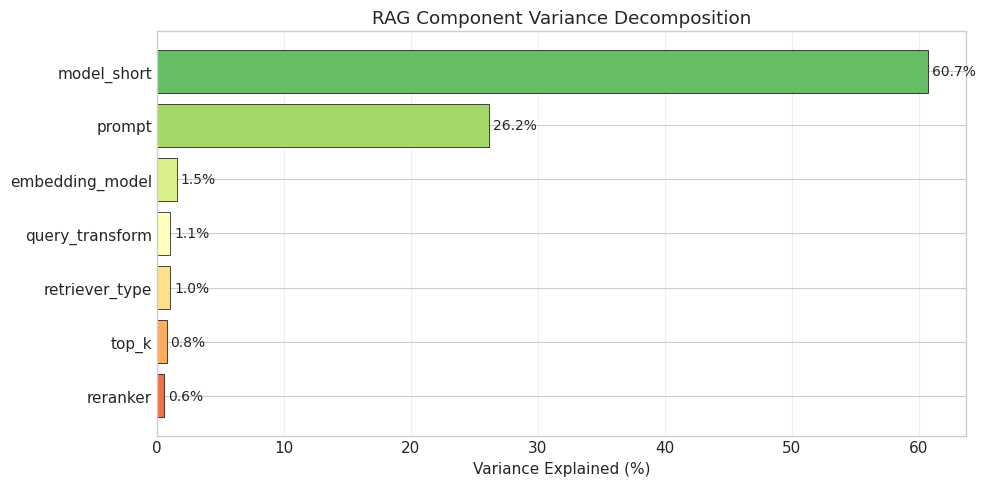

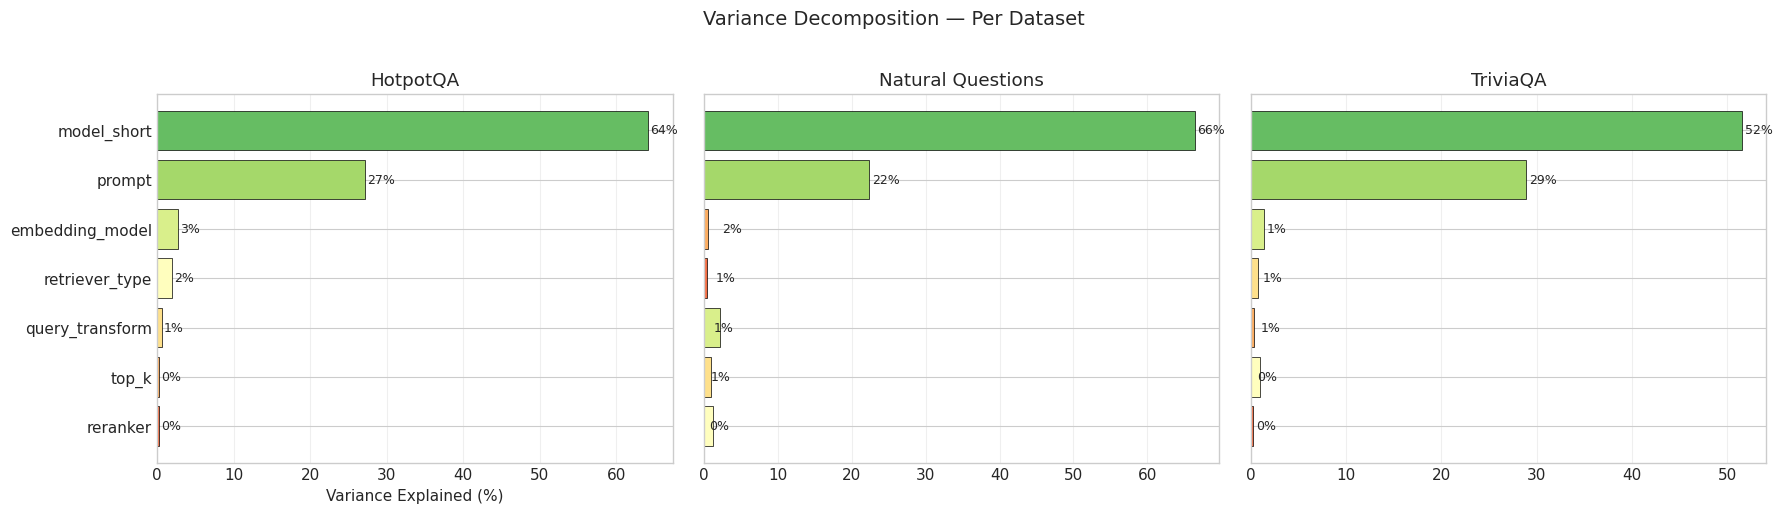

In [2]:
bottlenecks = identify_bottlenecks(df, PRIMARY_METRIC)

if bottlenecks:
    print("Variance Explained by Factor (%)")
    print("=" * 50)
    for factor, pct in bottlenecks.items():
        bar = '#' * int(pct / 2)
        print(f"  {factor:<20s}: {pct:5.1f}%  {bar}")

    # Horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    factors = list(bottlenecks.keys())
    values = list(bottlenecks.values())
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(factors)))
    ax.barh(factors[::-1], values[::-1], color=colors[::-1], edgecolor='black', linewidth=0.5)
    ax.set_xlabel('Variance Explained (%)')
    ax.set_title('RAG Component Variance Decomposition')
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(values[::-1]):
        ax.text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()

    # --- Per-dataset faceted variance decomposition ---
    datasets = sorted(rag['dataset'].unique())
    if len(datasets) >= 2:
        fig, axes_ds = plt.subplots(1, len(datasets),
                                    figsize=(6 * len(datasets), 5), sharey=True)
        if len(datasets) == 1:
            axes_ds = [axes_ds]

        for ax_i, ds in zip(axes_ds, datasets):
            ds_df = df[df['dataset'] == ds]
            ds_bn = identify_bottlenecks(ds_df, PRIMARY_METRIC, stratify_by=None)
            if not ds_bn:
                ax_i.set_title(DATASET_LABELS.get(ds, ds))
                ax_i.text(0.5, 0.5, 'Insufficient data', ha='center', va='center',
                          transform=ax_i.transAxes)
                continue
            ds_factors = list(ds_bn.keys())
            ds_values = list(ds_bn.values())
            ds_colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(ds_factors)))
            ax_i.barh(ds_factors[::-1], ds_values[::-1],
                      color=ds_colors[::-1], edgecolor='black', linewidth=0.5)
            if ax_i == axes_ds[0]:
                ax_i.set_xlabel('Variance Explained (%)')
            ax_i.set_title(DATASET_LABELS.get(ds, ds))
            ax_i.grid(axis='x', alpha=0.3)
            for i, v in enumerate(ds_values[::-1]):
                ax_i.text(v + 0.3, i, f'{v:.0f}%', va='center', fontsize=9)

        fig.suptitle('Variance Decomposition — Per Dataset', y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()

### Multi-Metric Variance Decomposition

**Key thesis question:** Do different quality dimensions depend on the same components?

If reranker dominates F1 but not faithfulness, it means reranking improves correctness
without improving groundedness. If model_short dominates everything,
retrieval investment is less impactful regardless of what we measure.

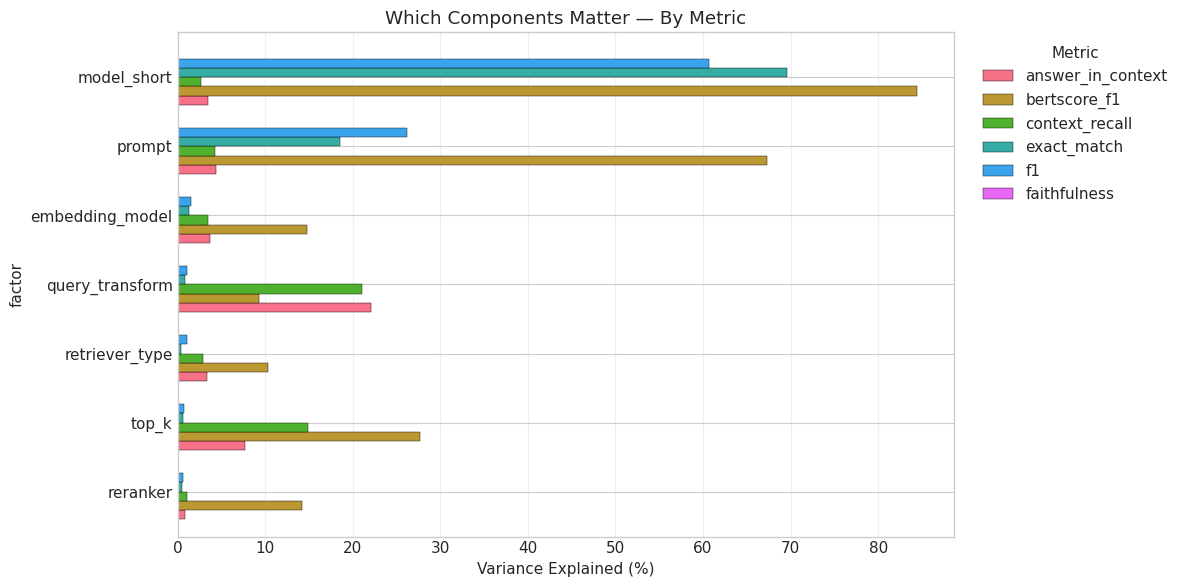


Variance Explained (%) by Factor and Metric:


metric,answer_in_context,bertscore_f1,context_recall,exact_match,f1,faithfulness
factor,,,,,,
reranker,0.8,14.2,1.1,0.5,0.6,0.0
top_k,7.7,27.7,14.9,0.7,0.8,0.0
retriever_type,3.4,10.3,2.9,0.4,1.0,0.0
query_transform,22.1,9.3,21.1,0.9,1.1,0.0
embedding_model,3.7,14.8,3.5,1.3,1.5,0.0
prompt,4.4,67.3,4.3,18.6,26.2,0.0
model_short,3.5,84.4,2.7,69.6,60.7,0.0



Key divergences (factor importance differs >5pp across metrics):
  reranker: bertscore_f1=14.2% vs faithfulness=0.0% (spread=14.2pp)
  top_k: bertscore_f1=27.7% vs faithfulness=0.0% (spread=27.7pp)
  retriever_type: bertscore_f1=10.3% vs faithfulness=0.0% (spread=10.3pp)
  query_transform: answer_in_context=22.1% vs faithfulness=0.0% (spread=22.1pp)
  embedding_model: bertscore_f1=14.8% vs faithfulness=0.0% (spread=14.8pp)
  prompt: bertscore_f1=67.3% vs faithfulness=0.0% (spread=67.3pp)
  model_short: bertscore_f1=84.4% vs faithfulness=0.0% (spread=84.4pp)


In [3]:
# Multi-metric variance decomposition
mm_df = multi_metric_bottlenecks_df(df, metrics=available_metrics)

if not mm_df.empty:
    # Pivot for grouped bar chart: factors as rows, metrics as columns
    mm_pivot = mm_df.pivot(index='factor', columns='metric', values='variance_pct').fillna(0)

    # Sort factors by F1 variance (or first available metric)
    sort_metric = PRIMARY_METRIC if PRIMARY_METRIC in mm_pivot.columns else mm_pivot.columns[0]
    mm_pivot = mm_pivot.sort_values(sort_metric, ascending=True)

    fig, ax = plt.subplots(figsize=(12, 6))
    mm_pivot.plot(kind='barh', ax=ax, width=0.8, edgecolor='black', linewidth=0.3)
    ax.set_xlabel('Variance Explained (%)')
    ax.set_title('Which Components Matter — By Metric')
    ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print the table
    print("\nVariance Explained (%) by Factor and Metric:")
    print("=" * 70)
    display(mm_pivot.round(1))

    # Highlight divergences: where do metrics disagree about what matters?
    print("\nKey divergences (factor importance differs >5pp across metrics):")
    for factor in mm_pivot.index:
        vals = mm_pivot.loc[factor]
        spread = vals.max() - vals.min()
        if spread > 5:
            top_metric = vals.idxmax()
            low_metric = vals.idxmin()
            print(f"  {factor}: {top_metric}={vals[top_metric]:.1f}% vs "
                  f"{low_metric}={vals[low_metric]:.1f}% (spread={spread:.1f}pp)")
else:
    print("Not enough metric data for multi-metric variance decomposition.")

## 2. Marginal Effects

Marginal mean of each factor level, controlling for model and dataset.

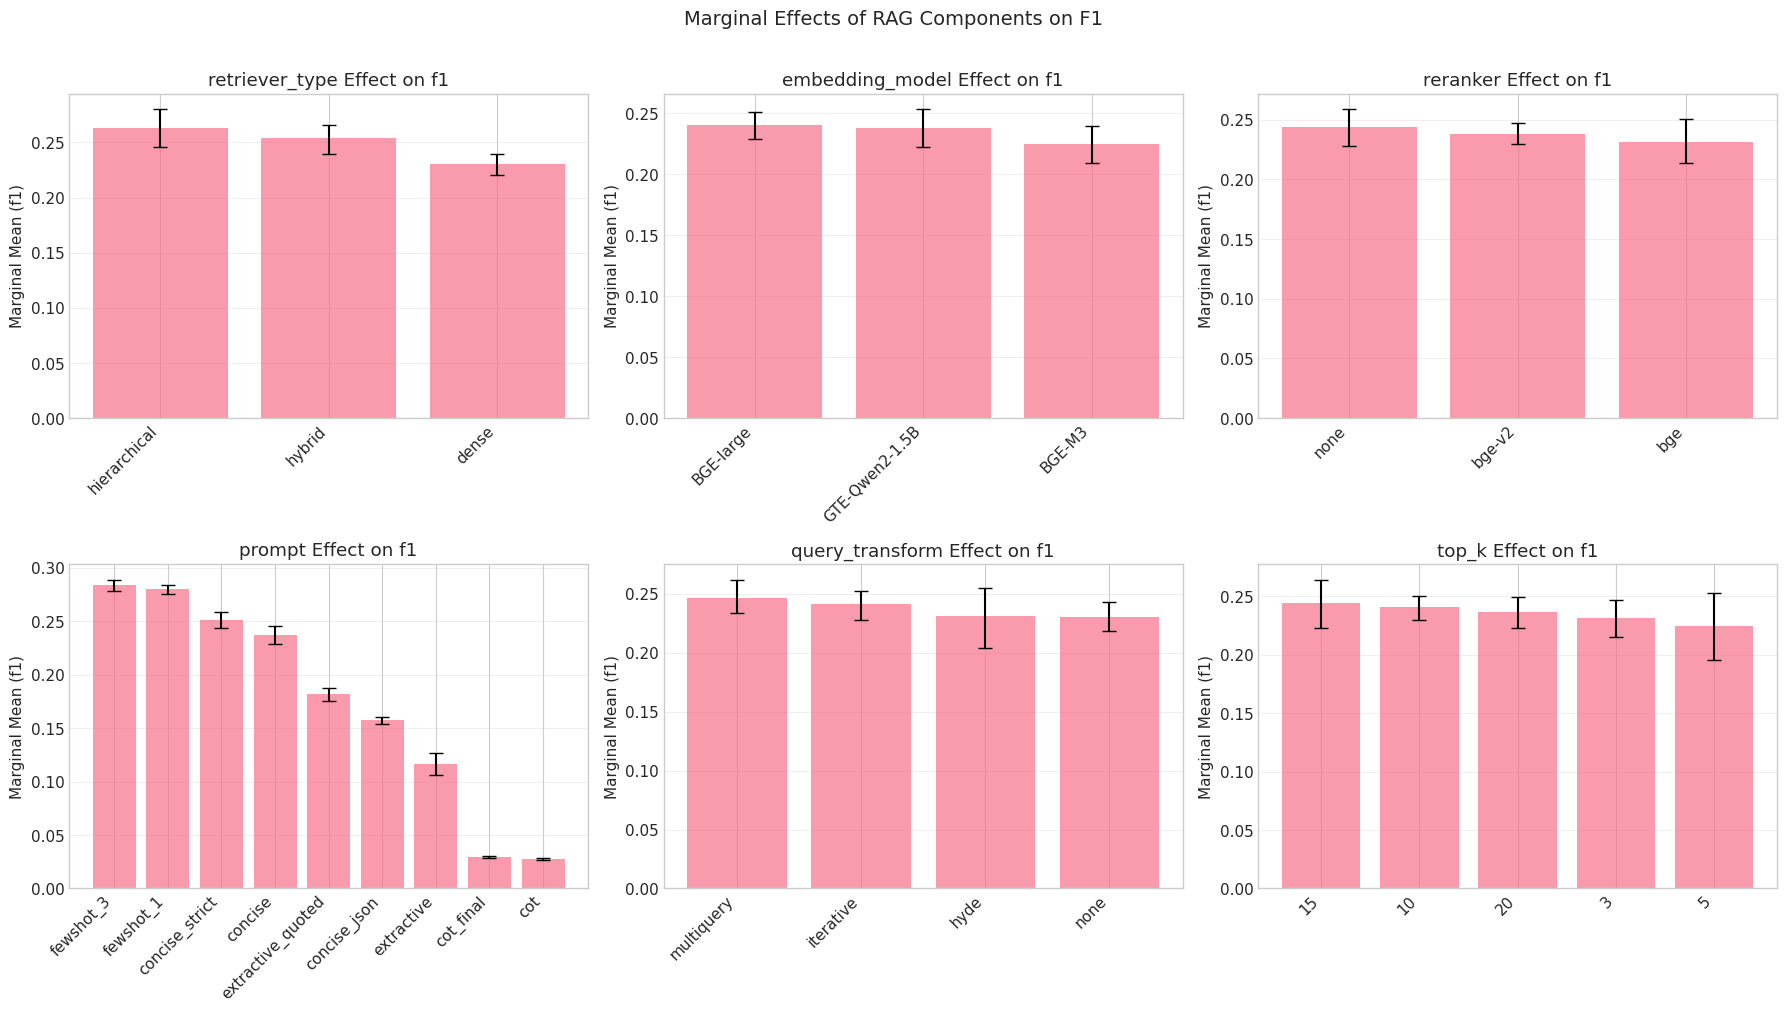

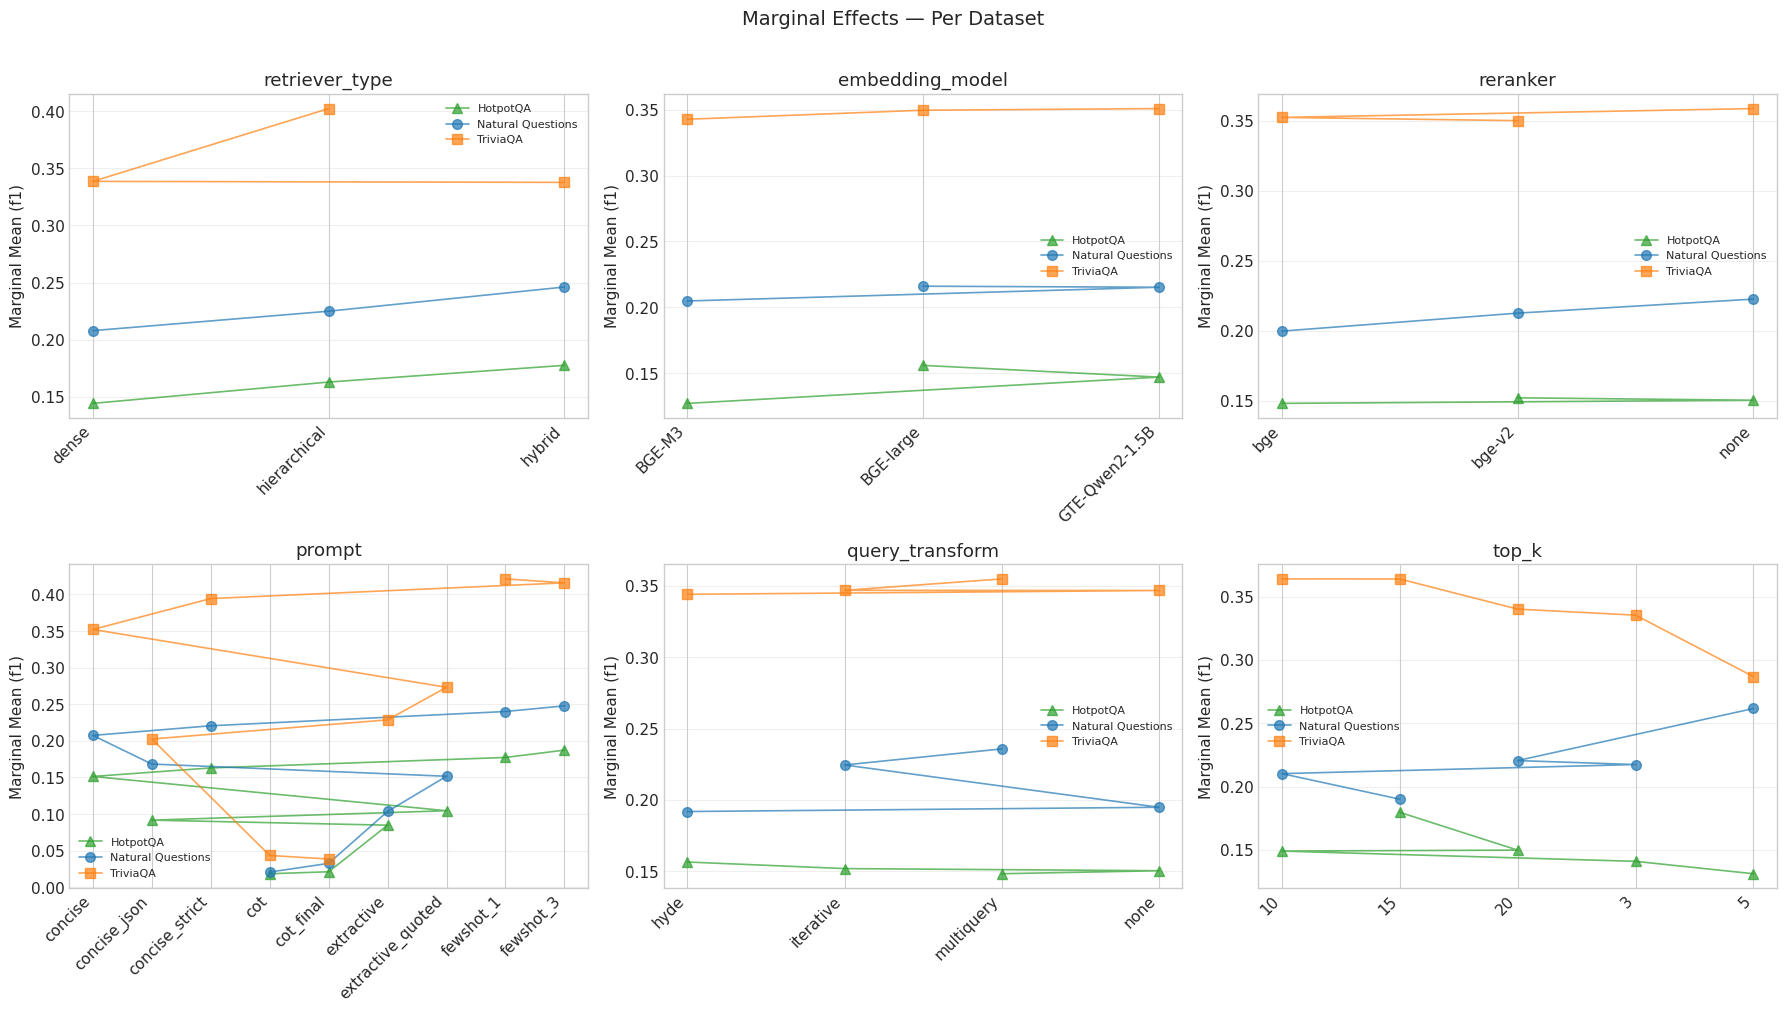

In [4]:
factors = ['retriever_type', 'embedding_model', 'reranker', 'prompt',
           'query_transform', 'top_k']
# Filter to factors present with > 1 level
factors = [f for f in factors if f in rag.columns and rag[f].nunique() > 1]

n_factors = len(factors)
ncols = min(3, n_factors)
nrows = (n_factors + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
if n_factors == 1:
    axes = np.array([axes])
axes = np.atleast_2d(axes)

for idx, factor in enumerate(factors):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]
    plot_component_effects(df, factor, PRIMARY_METRIC, ax=ax)

# Hide unused axes
for idx in range(n_factors, nrows * ncols):
    r, c = divmod(idx, ncols)
    axes[r, c].set_visible(False)

plt.suptitle('Marginal Effects of RAG Components on F1', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

# --- Per-dataset overlay: dot+line per dataset on same axes ---
datasets = sorted(rag['dataset'].unique())
if len(datasets) >= 2 and len(factors) > 0:
    fig2, axes2 = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
    if n_factors == 1:
        axes2 = np.array([axes2])
    axes2 = np.atleast_2d(axes2)

    for idx, factor in enumerate(factors):
        r, c = divmod(idx, ncols)
        ax = axes2[r, c]
        # Compute marginal means per dataset
        all_levels = sorted(rag[factor].dropna().unique(), key=str)

        for ds in datasets:
            ds_rag = rag[rag['dataset'] == ds]
            ds_df_full = df[df['dataset'] == ds]
            marginal = compute_marginal_means(
                ds_df_full[ds_df_full['exp_type'] == 'rag'], factor, PRIMARY_METRIC,
                control_vars=['model_short'],
            )
            if marginal.empty:
                continue
            # Align x positions with the all_levels order
            x_map = {str(lvl): i for i, lvl in enumerate(all_levels)}
            xs = [x_map[str(lvl)] for lvl in marginal[factor] if str(lvl) in x_map]
            ys = [marginal.loc[marginal[factor] == lvl, 'marginal_mean'].iloc[0]
                  for lvl in marginal[factor] if str(lvl) in x_map]
            color = DATASET_COLORS.get(ds, 'grey')
            marker = DATASET_MARKERS.get(ds, 'o')
            label = DATASET_LABELS.get(ds, ds)
            ax.plot(xs, ys, marker=marker, color=color, markersize=7,
                    linewidth=1.2, alpha=0.7, label=label)

        ax.set_xticks(range(len(all_levels)))
        ax.set_xticklabels([str(l) for l in all_levels], rotation=45, ha='right')
        ax.set_ylabel(f'Marginal Mean ({PRIMARY_METRIC})')
        ax.set_title(f'{factor}')
        ax.legend(fontsize=8)
        ax.grid(axis='y', alpha=0.3)

    for idx in range(n_factors, nrows * ncols):
        r, c = divmod(idx, ncols)
        axes2[r, c].set_visible(False)

    fig2.suptitle('Marginal Effects — Per Dataset', y=1.01, fontsize=14)
    plt.tight_layout()
    plt.show()

## 3. Prompt Deep Dive

Prompt Performance (mean F1 with 95% CI):


,prompt,mean,std,ci_low,ci_high,n,min,max
0,fewshot_3,0.2953,0.1640,0.2603,0.3299,60,0.0272,0.6535
1,concise_strict,0.2877,0.1475,0.2348,0.3327,44,0.0389,0.6674
2,fewshot_1,0.2786,0.1764,0.2640,0.2944,319,0.0232,0.6777
3,concise,0.2218,0.1765,0.1859,0.2544,87,0.0198,0.6429
4,extractive_quoted,0.1901,0.1699,0.1549,0.2271,52,0.0152,0.6123
5,concise_json,0.1517,0.1003,0.1211,0.1834,29,0.0341,0.4205
6,extractive,0.1475,0.1168,0.1072,0.1874,25,0.0120,0.4413
7,cot,0.0305,0.0206,0.0262,0.0356,27,0.0113,0.0951
8,cot_final,0.0301,0.0150,0.0255,0.0361,25,0.0111,0.0779


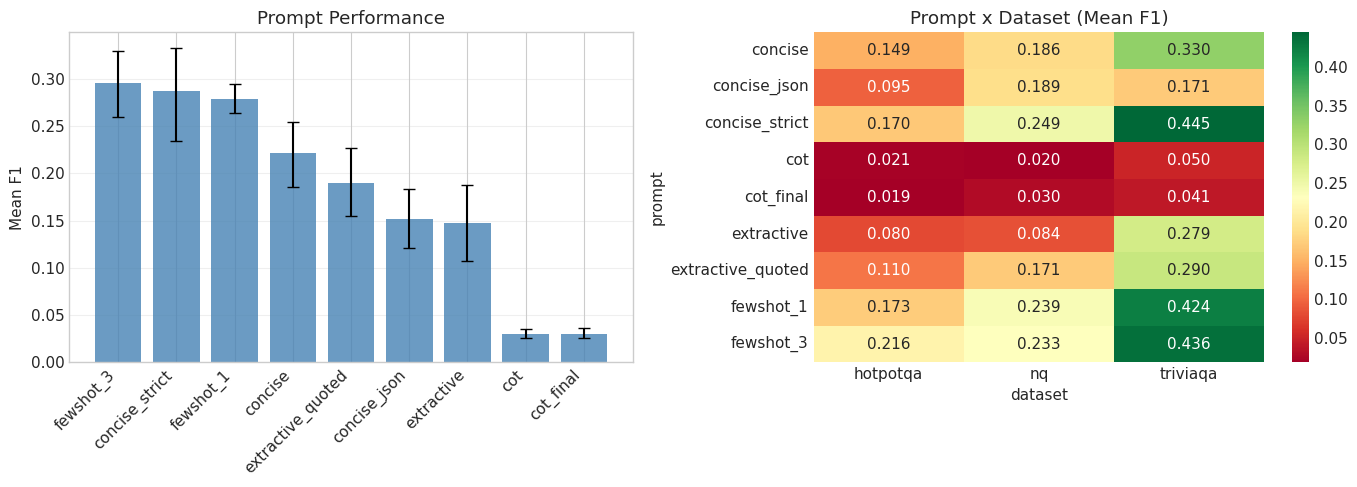

In [5]:
# Prompt marginal means with CI
prompt_stats = weighted_mean_with_ci(rag, 'prompt', PRIMARY_METRIC)
print("Prompt Performance (mean F1 with 95% CI):")
display(prompt_stats.round(4))

# Prompt x Dataset heatmap
prompt_ds = rag.groupby(['prompt', 'dataset'])[PRIMARY_METRIC].mean().unstack()
if not prompt_ds.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart
    x = range(len(prompt_stats))
    yerr_low = np.maximum(prompt_stats['mean'] - prompt_stats['ci_low'], 0)
    yerr_high = np.maximum(prompt_stats['ci_high'] - prompt_stats['mean'], 0)
    axes[0].bar(x, prompt_stats['mean'], yerr=[yerr_low, yerr_high],
               capsize=4, alpha=0.8, color='steelblue')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(prompt_stats['prompt'], rotation=45, ha='right')
    axes[0].set_ylabel('Mean F1')
    axes[0].set_title('Prompt Performance')
    axes[0].grid(axis='y', alpha=0.3)

    # Heatmap
    sns.heatmap(prompt_ds, annot=True, fmt='.3f', cmap='RdYlGn',
                ax=axes[1])
    axes[1].set_title('Prompt x Dataset (Mean F1)')

    plt.tight_layout()
    plt.show()

## 4. Top-K Sensitivity

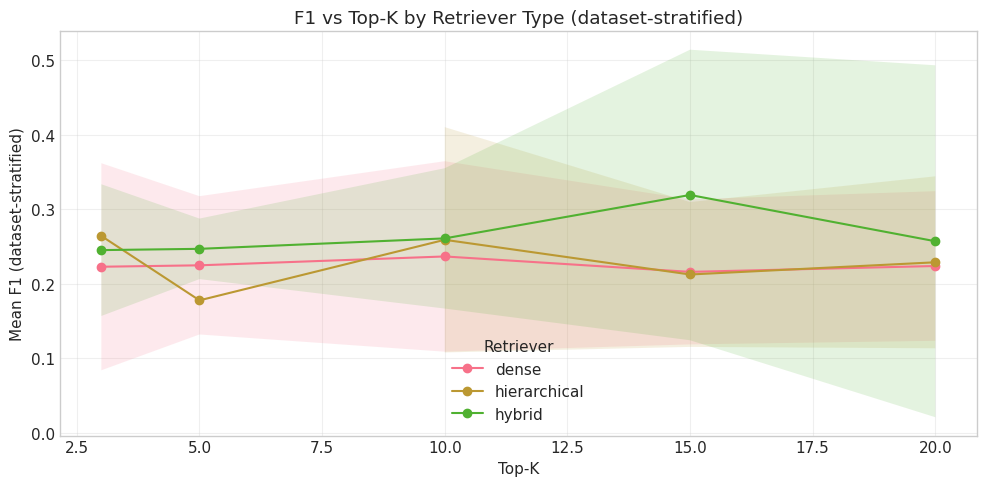

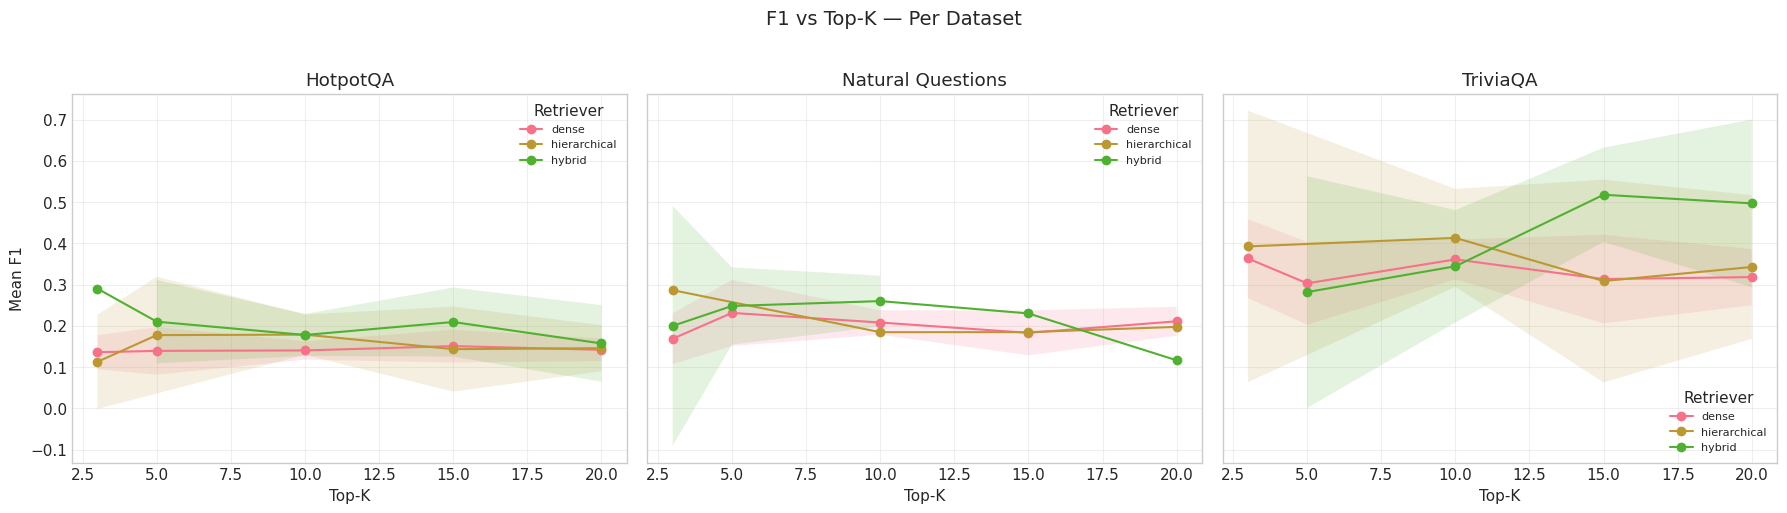

In [6]:
# Top-K sensitivity — stratified by dataset
if 'top_k' in rag.columns and rag['top_k'].nunique() > 1:
    topk_data = rag.dropna(subset=['top_k', PRIMARY_METRIC])
    retriever_types = sorted(topk_data['retriever_type'].dropna().unique())

    fig, ax = plt.subplots(figsize=(10, 5))

    for rt in retriever_types:
        sub = topk_data[topk_data['retriever_type'] == rt]
        # Stratify: per (top_k, dataset) mean, then average across datasets
        per_ds = sub.groupby(['top_k', 'dataset'])[PRIMARY_METRIC].mean()
        means = per_ds.groupby('top_k').agg(['mean', 'std', 'count'])
        means.columns = ['mean', 'std', 'count']
        means = means.sort_index()
        ci = 1.96 * means['std'] / np.sqrt(np.maximum(means['count'], 1))
        ax.plot(means.index, means['mean'], marker='o', label=rt)
        ax.fill_between(means.index, means['mean'] - ci, means['mean'] + ci, alpha=0.15)

    ax.set_xlabel('Top-K')
    ax.set_ylabel('Mean F1 (dataset-stratified)')
    ax.set_title('F1 vs Top-K by Retriever Type (dataset-stratified)')
    ax.legend(title='Retriever')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Per-dataset faceted top-K sensitivity ---
    datasets = sorted(topk_data['dataset'].unique())
    if len(datasets) >= 2:
        fig, axes_ds = plt.subplots(1, len(datasets),
                                    figsize=(6 * len(datasets), 5), sharey=True)
        if len(datasets) == 1:
            axes_ds = [axes_ds]

        for ax_i, ds in zip(axes_ds, datasets):
            ds_topk = topk_data[topk_data['dataset'] == ds]
            for rt in retriever_types:
                sub = ds_topk[ds_topk['retriever_type'] == rt]
                if sub.empty:
                    continue
                means = sub.groupby('top_k')[PRIMARY_METRIC].agg(['mean', 'std', 'count'])
                means = means.sort_index()
                ci = 1.96 * means['std'] / np.sqrt(np.maximum(means['count'], 1))
                ax_i.plot(means.index, means['mean'], marker='o', label=rt)
                ax_i.fill_between(means.index, means['mean'] - ci,
                                  means['mean'] + ci, alpha=0.15)

            ax_i.set_xlabel('Top-K')
            if ax_i == axes_ds[0]:
                ax_i.set_ylabel('Mean F1')
            ax_i.set_title(DATASET_LABELS.get(ds, ds))
            ax_i.legend(fontsize=8, title='Retriever')
            ax_i.grid(alpha=0.3)

        fig.suptitle('F1 vs Top-K — Per Dataset', y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()
else:
    print("Top-K has <= 1 unique value; skipping sensitivity plot.")

## 5. Interaction Effects

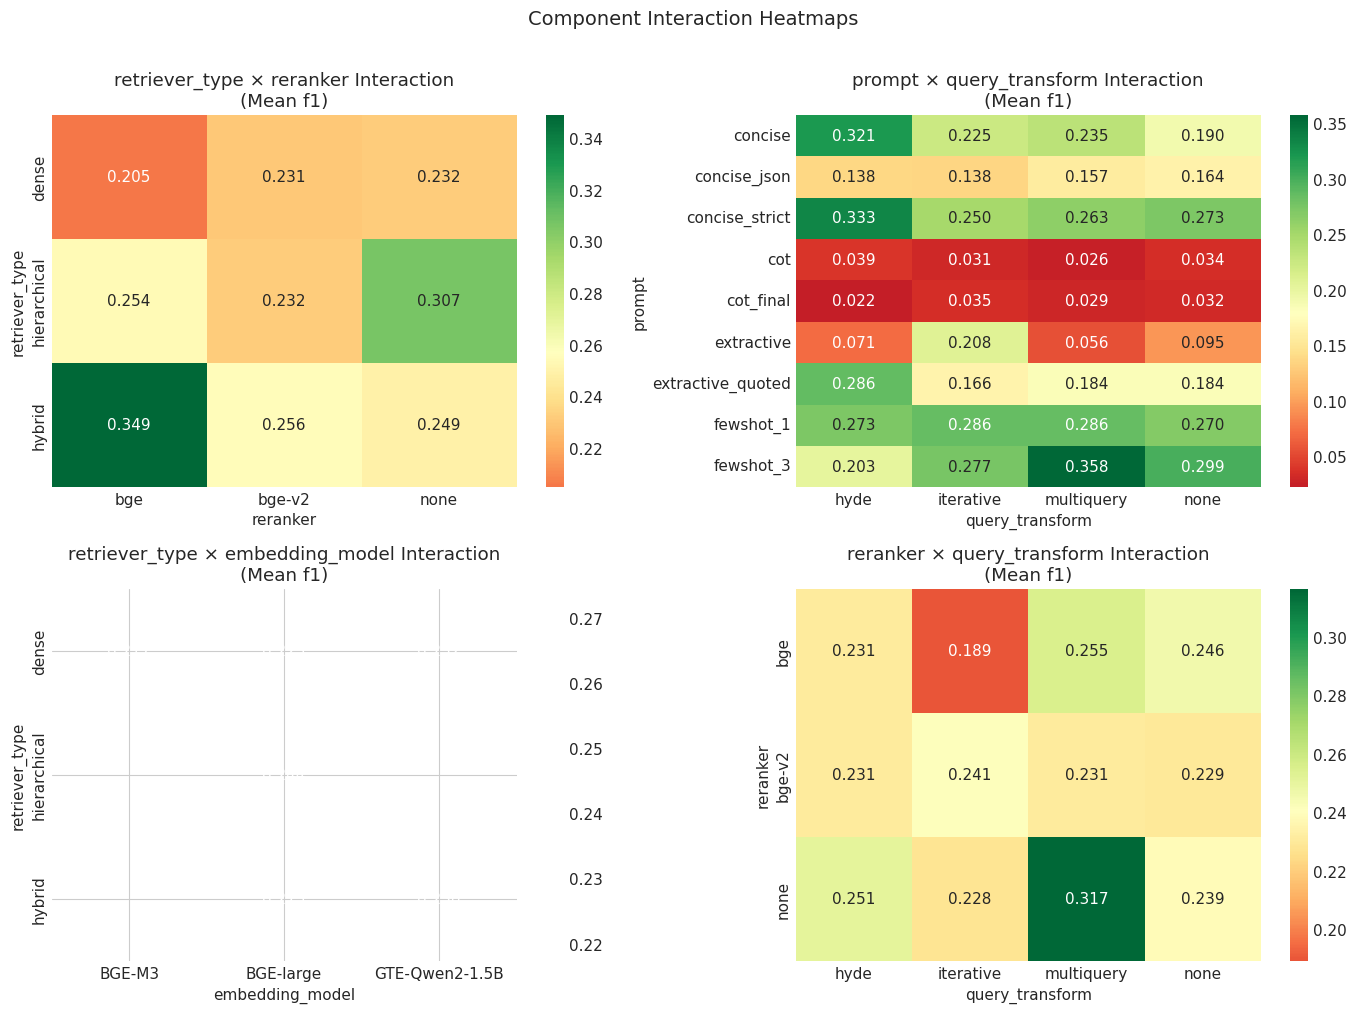

In [7]:
interaction_pairs = [
    ('retriever_type', 'reranker'),
    ('prompt', 'query_transform'),
    ('retriever_type', 'embedding_model'),
    ('reranker', 'query_transform'),
]
# Filter to pairs where both factors have > 1 level
interaction_pairs = [(f1, f2) for f1, f2 in interaction_pairs
                     if f1 in rag.columns and f2 in rag.columns
                     and rag[f1].nunique() > 1 and rag[f2].nunique() > 1]

n_pairs = len(interaction_pairs)
if n_pairs > 0:
    ncols = min(2, n_pairs)
    nrows = (n_pairs + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 5 * nrows))
    if n_pairs == 1:
        axes = np.array([axes])
    axes_flat = np.atleast_1d(axes).flatten()

    for idx, (f1, f2) in enumerate(interaction_pairs):
        plot_interaction_heatmap(df, f1, f2, PRIMARY_METRIC, ax=axes_flat[idx])

    for idx in range(n_pairs, len(axes_flat)):
        axes_flat[idx].set_visible(False)

    plt.suptitle('Component Interaction Heatmaps', y=1.01, fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough factor pairs with multiple levels for interaction analysis.")

In [8]:
# Synergistic / redundant combos
for f1, f2 in interaction_pairs:
    combos = find_synergistic_combinations(df, f1, f2, PRIMARY_METRIC)
    if combos:
        combo_df = pd.DataFrame(combos)
        syn = combo_df[combo_df['synergy'] == 'Synergistic']
        red = combo_df[combo_df['synergy'] == 'Redundant']
        print(f"\n{f1} x {f2}:")
        if len(syn) > 0:
            print(f"  Synergistic ({len(syn)}):")
            for _, r in syn.head(3).iterrows():
                print(f"    {r[f1]} + {r[f2]}: interaction = +{r['interaction_effect']:.4f}")
        if len(red) > 0:
            print(f"  Redundant ({len(red)}):")
            for _, r in red.head(3).iterrows():
                print(f"    {r[f1]} + {r[f2]}: interaction = {r['interaction_effect']:.4f}")


retriever_type x reranker:
  Synergistic (3):
    hybrid + bge: interaction = +0.0832
    hierarchical + none: interaction = +0.0565
    hierarchical + bge: interaction = +0.0124
  Redundant (4):
    hierarchical + bge-v2: interaction = -0.0108
    hybrid + bge-v2: interaction = -0.0115
    dense + bge: interaction = -0.0216

prompt x query_transform:
  Synergistic (7):
    concise + hyde: interaction = +0.1027
    extractive_quoted + hyde: interaction = +0.1000
    extractive + iterative: interaction = +0.0602
  Redundant (11):
    concise_strict + none: interaction = -0.0117
    cot + multiquery: interaction = -0.0119
    extractive_quoted + multiquery: interaction = -0.0126

retriever_type x embedding_model:
  Redundant (1):
    hybrid + GTE-Qwen2-1.5B: interaction = -0.0545

reranker x query_transform:
  Synergistic (4):
    none + multiquery: interaction = +0.0689
    bge + none: interaction = +0.0171
    bge + multiquery: interaction = +0.0160
  Redundant (2):
    none + iterati

### 5a. Dataset-Conditional Interaction Effects

**Key question:** Do interaction patterns hold across all datasets, or are synergies dataset-specific?

If reranker x retriever synergy only appears on HotpotQA (multi-hop), it suggests
the synergy is driven by question complexity rather than being universal.

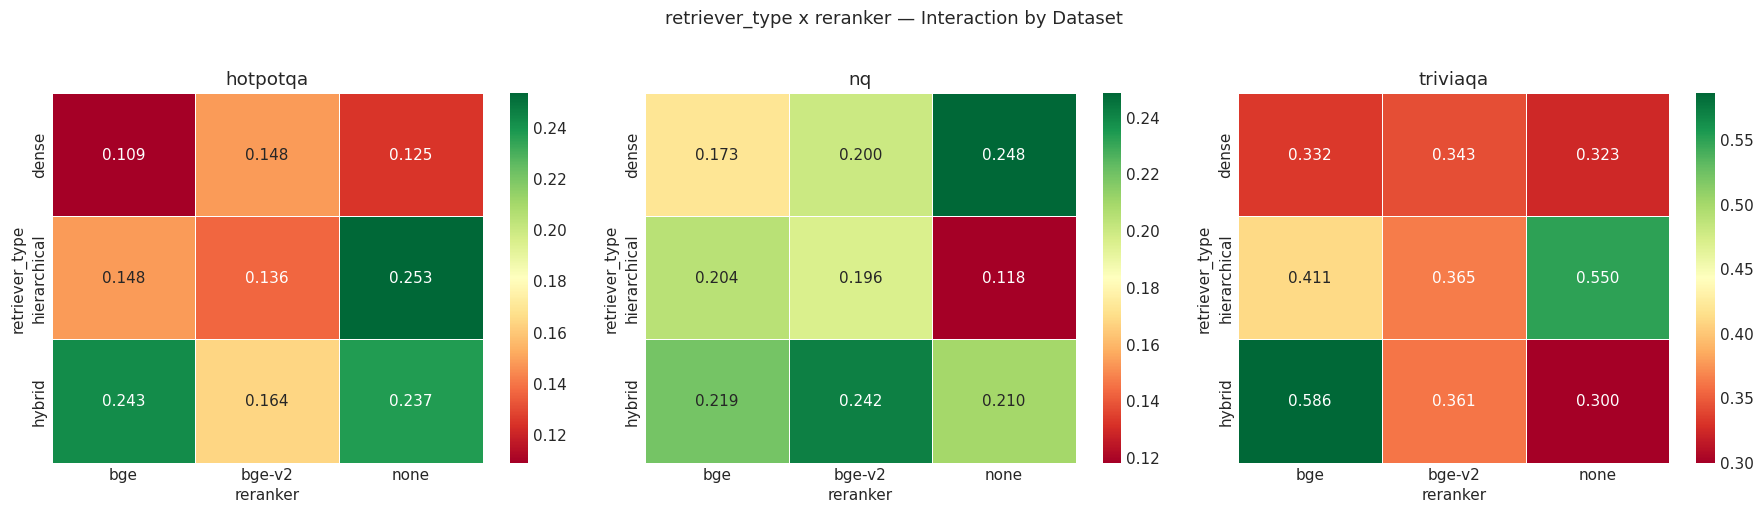

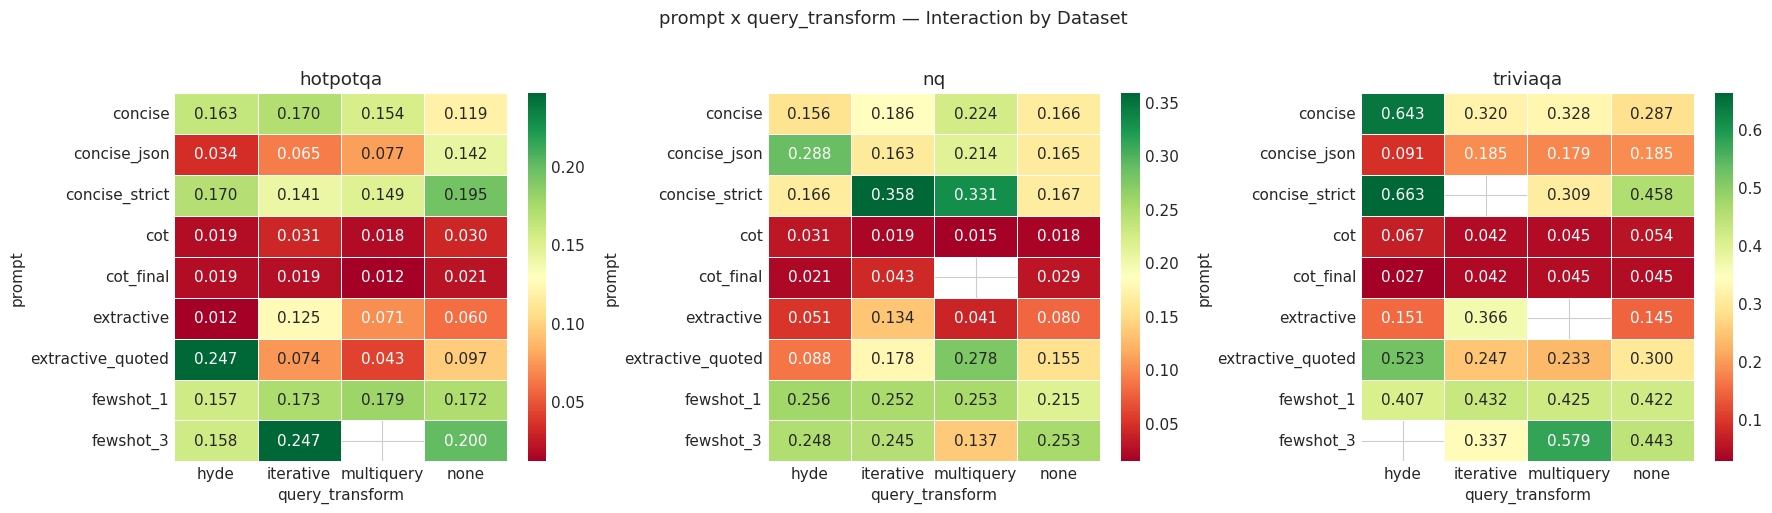


Interaction Stability Across Datasets:

  retriever_type x reranker:
    3/9 combos have same-sign interaction across all datasets
    Dataset-sensitive combos (sign flips):
      hierarchical+none: hotpotqa=+0.0885, nq=-0.1047, triviaqa=+0.1857
      hybrid+none: hotpotqa=+0.0470, nq=-0.0508, triviaqa=-0.0733
      hybrid+bge-v2: hotpotqa=-0.0215, nq=+0.0145, triviaqa=-0.0275

  prompt x query_transform:
    6/31 combos have same-sign interaction across all datasets
    Dataset-sensitive combos (sign flips):
      concise+hyde: hotpotqa=+0.0185, nq=-0.0074, triviaqa=+0.2972
      extractive_quoted+hyde: hotpotqa=+0.1418, nq=-0.0598, triviaqa=+0.2180
      concise_strict+hyde: hotpotqa=+0.0047, nq=-0.0600, triviaqa=+0.2034


In [9]:
# Dataset-conditional interaction effects
# Show the top 2 most important interaction pairs broken out by dataset
ds_list = sorted(rag['dataset'].unique())
top_pairs = interaction_pairs[:2]  # Use same pairs from section 5

if len(ds_list) >= 2 and len(top_pairs) >= 1:
    for f1, f2 in top_pairs:
        n_ds = len(ds_list)
        fig, axes = plt.subplots(1, n_ds, figsize=(6 * n_ds, 5))
        if n_ds == 1:
            axes = [axes]

        for i, ds in enumerate(ds_list):
            ds_rag = rag[rag['dataset'] == ds]
            if ds_rag[f1].nunique() > 1 and ds_rag[f2].nunique() > 1:
                pivot = ds_rag.groupby([f1, f2])[PRIMARY_METRIC].mean().unstack()
                sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                            ax=axes[i], linewidths=0.5)
            axes[i].set_title(f'{ds}')

        plt.suptitle(f'{f1} x {f2} — Interaction by Dataset', y=1.02, fontsize=13)
        plt.tight_layout()
        plt.show()

    # Quantify: does the interaction effect change sign or magnitude across datasets?
    print("\nInteraction Stability Across Datasets:")
    print("=" * 60)
    for f1, f2 in top_pairs:
        print(f"\n  {f1} x {f2}:")
        ds_effects = {}
        for ds in ds_list:
            ds_rag = rag[rag['dataset'] == ds]
            combos = find_synergistic_combinations(ds_rag, f1, f2, PRIMARY_METRIC)
            if combos:
                combo_df = pd.DataFrame(combos)
                ds_effects[ds] = combo_df.set_index([f1, f2])['interaction_effect']

        if len(ds_effects) >= 2:
            # Find combos present in all datasets
            all_idx = set.intersection(*[set(e.index) for e in ds_effects.values()])
            if all_idx:
                effect_df = pd.DataFrame({ds: e.loc[list(all_idx)]
                                          for ds, e in ds_effects.items()})
                effect_df['sign_stable'] = (effect_df[ds_list] > 0).all(axis=1) | \
                                           (effect_df[ds_list] < 0).all(axis=1)
                n_stable = effect_df['sign_stable'].sum()
                n_total = len(effect_df)
                print(f"    {n_stable}/{n_total} combos have same-sign interaction across all datasets")

                # Show top combos where sign FLIPS
                unstable = effect_df[~effect_df['sign_stable']].copy()
                if not unstable.empty:
                    unstable['spread'] = unstable[ds_list].max(axis=1) - unstable[ds_list].min(axis=1)
                    print(f"    Dataset-sensitive combos (sign flips):")
                    for idx, row in unstable.nlargest(3, 'spread').iterrows():
                        vals = ', '.join(f"{ds}={row[ds]:+.4f}" for ds in ds_list)
                        print(f"      {idx[0]}+{idx[1]}: {vals}")
                else:
                    print(f"    All interaction effects are sign-stable across datasets!")
else:
    print("Need >= 2 datasets and >= 1 interaction pair for conditional analysis.")

## 5c. Retrieval Quality Pipeline: Context Recall → F1

**Key question:** Is retrieval quality a sufficient predictor of downstream answer quality?

If context_recall strongly predicts F1, the pipeline is retrieval-bottlenecked.
If the correlation is weak, generation quality matters independently.

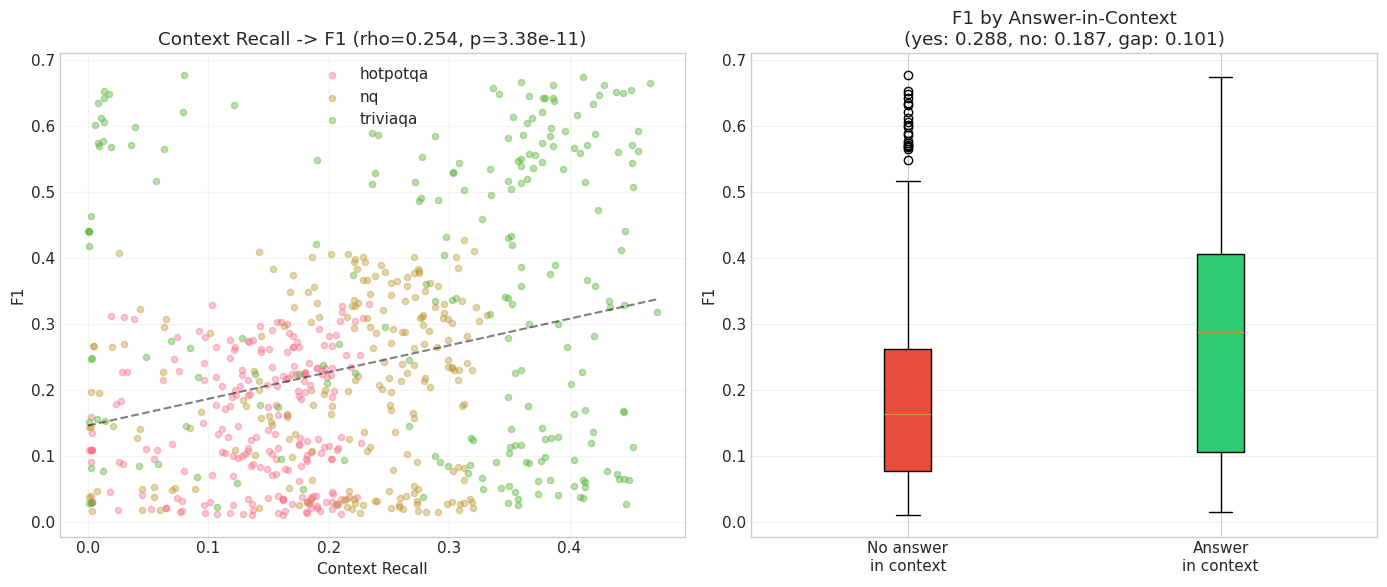


Context Recall by RAG Component (dataset-stratified means):

  retriever_type:
    dense               : 0.223 (n=520)
    hybrid              : 0.202 (n=62)
    hierarchical        : 0.182 (n=80)

  reranker:
    bge-v2              : 0.221 (n=492)
    bge                 : 0.204 (n=80)
    none                : 0.198 (n=90)

  top_k:
    15                  : 0.255 (n=76)
    20                  : 0.251 (n=176)
    10                  : 0.211 (n=294)
    5                   : 0.176 (n=52)
    3                   : 0.131 (n=64)

  embedding_model:
    GTE-Qwen2-1.5B      : 0.233 (n=122)
    BGE-large           : 0.221 (n=426)
    BGE-M3              : 0.182 (n=114)


In [10]:
if has_ctx_recall or has_aic:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Context Recall vs F1
    if has_ctx_recall:
        cr_df = rag.dropna(subset=[PRIMARY_METRIC, 'context_recall'])
        ax = axes[0]
        for ds in sorted(cr_df['dataset'].unique()):
            sub = cr_df[cr_df['dataset'] == ds]
            ax.scatter(sub['context_recall'], sub[PRIMARY_METRIC],
                       s=20, alpha=0.4, label=ds)
        rho, p = scipy_stats.spearmanr(cr_df['context_recall'], cr_df[PRIMARY_METRIC])
        z = np.polyfit(cr_df['context_recall'], cr_df[PRIMARY_METRIC], 1)
        x_line = np.linspace(cr_df['context_recall'].min(), cr_df['context_recall'].max(), 50)
        ax.plot(x_line, np.polyval(z, x_line), 'k--', alpha=0.5)
        ax.set_xlabel('Context Recall')
        ax.set_ylabel('F1')
        ax.set_title(f'Context Recall -> F1 (rho={rho:.3f}, p={p:.2e})')
        ax.legend()
        ax.grid(alpha=0.2)

    # Answer-in-Context vs F1
    if has_aic:
        aic_df = rag.dropna(subset=[PRIMARY_METRIC, 'answer_in_context'])
        ax = axes[1]
        ctx_yes = aic_df[aic_df['answer_in_context'] >= 0.5][PRIMARY_METRIC]
        ctx_no = aic_df[aic_df['answer_in_context'] < 0.5][PRIMARY_METRIC]
        bp = ax.boxplot([ctx_no.values, ctx_yes.values],
                        labels=['No answer\nin context', 'Answer\nin context'],
                        patch_artist=True)
        bp['boxes'][0].set_facecolor('#e74c3c')
        bp['boxes'][1].set_facecolor('#2ecc71')
        ax.set_ylabel('F1')
        ax.set_title(f'F1 by Answer-in-Context\n'
                     f'(yes: {ctx_yes.mean():.3f}, no: {ctx_no.mean():.3f}, '
                     f'gap: {ctx_yes.mean() - ctx_no.mean():.3f})')
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Component impact on context_recall — stratified by dataset
    if has_ctx_recall:
        print("\nContext Recall by RAG Component (dataset-stratified means):")
        print("=" * 60)
        for factor in ['retriever_type', 'reranker', 'top_k', 'embedding_model']:
            if factor in cr_df.columns and cr_df[factor].nunique() > 1:
                # Per (factor, dataset) mean, then average across datasets
                per_ds = cr_df.groupby([factor, 'dataset'])['context_recall'].mean()
                strat_means = per_ds.groupby(factor).mean().sort_values(ascending=False)
                counts = cr_df.groupby(factor)['context_recall'].count()
                print(f"\n  {factor}:")
                for level in strat_means.index:
                    print(f"    {str(level):<20s}: {strat_means[level]:.3f} (n={int(counts.get(level, 0))})")
else:
    print("Context-aware metrics not available. Run:")
    print("  uv run ragicamp compute-metrics outputs/smart_retrieval_slm -m answer_in_context,context_recall")

## 5b. Faithfulness vs Correctness Trade-off

**Key thesis insight:** Are correct answers grounded in context, or are models hallucinating right answers?

- **Top-right** (high F1 + high faithfulness): Ideal — correct AND grounded
- **Bottom-right** (high F1 + low faithfulness): Correct but ungrounded — lucky hallucination
- **Top-left** (low F1 + high faithfulness): Faithful but wrong — retrieval failure

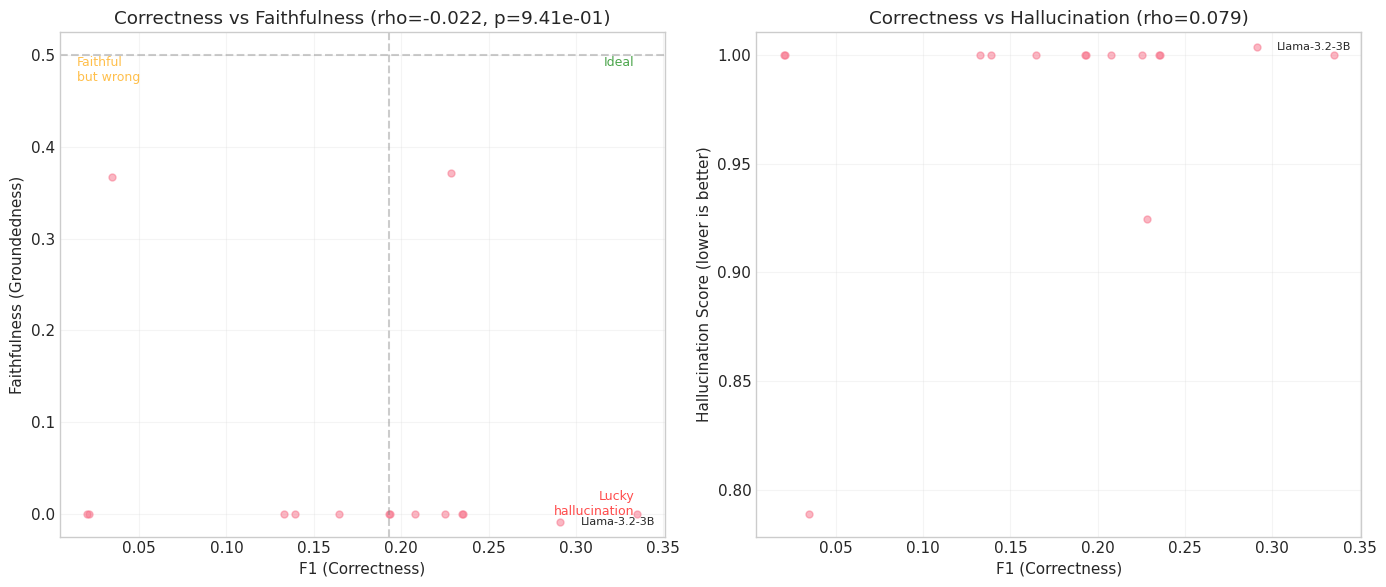


Faithfulness by RAG Component (dataset-stratified means):

  reranker:
    bge-v2              : 0.041 (n=10)
    bge                 : 0.000 (n=2)
    none                : 0.000 (n=2)

  prompt:
    concise_json        : 0.367 (n=1)
    fewshot_1           : 0.031 (n=7)
    concise             : 0.000 (n=1)
    concise_strict      : 0.000 (n=1)
    cot                 : 0.000 (n=1)
    cot_final           : 0.000 (n=1)
    fewshot_3           : 0.000 (n=2)

  query_transform:
    hyde                : 0.092 (n=4)
    iterative           : 0.027 (n=8)
    multiquery          : 0.000 (n=2)


In [11]:
if has_faith:
    faith_df = rag.dropna(subset=[PRIMARY_METRIC, 'faithfulness'])

    fig, axes = plt.subplots(1, 2 if has_halluc else 1,
                             figsize=(14 if has_halluc else 8, 6))
    if not has_halluc:
        axes = [axes]

    # Faithfulness vs F1 scatter
    ax = axes[0]
    for model in sorted(faith_df['model_short'].unique()):
        sub = faith_df[faith_df['model_short'] == model]
        ax.scatter(sub[PRIMARY_METRIC], sub['faithfulness'],
                   s=25, alpha=0.5, label=model)

    ax.axhline(y=0.5, color='grey', ls='--', alpha=0.4)
    ax.axvline(x=faith_df[PRIMARY_METRIC].median(), color='grey', ls='--', alpha=0.4)
    ax.set_xlabel('F1 (Correctness)')
    ax.set_ylabel('Faithfulness (Groundedness)')
    ax.grid(alpha=0.2)

    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.text(xlim[1] * 0.95, ylim[1] * 0.95, 'Ideal', ha='right', va='top',
            fontsize=9, color='green', alpha=0.7)
    ax.text(xlim[0] + 0.01, ylim[1] * 0.95, 'Faithful\nbut wrong', ha='left', va='top',
            fontsize=9, color='orange', alpha=0.7)
    ax.text(xlim[1] * 0.95, ylim[0] + 0.02, 'Lucky\nhallucination', ha='right', va='bottom',
            fontsize=9, color='red', alpha=0.7)

    rho, p = scipy_stats.spearmanr(faith_df[PRIMARY_METRIC], faith_df['faithfulness'])
    ax.set_title(f'Correctness vs Faithfulness (rho={rho:.3f}, p={p:.2e})')
    ax.legend(fontsize=8, loc='lower right')

    if has_halluc:
        ax2 = axes[1]
        halluc_df = rag.dropna(subset=[PRIMARY_METRIC, 'hallucination'])
        for model in sorted(halluc_df['model_short'].unique()):
            sub = halluc_df[halluc_df['model_short'] == model]
            ax2.scatter(sub[PRIMARY_METRIC], sub['hallucination'],
                       s=25, alpha=0.5, label=model)
        rho2, _ = scipy_stats.spearmanr(halluc_df[PRIMARY_METRIC], halluc_df['hallucination'])
        ax2.set_xlabel('F1 (Correctness)')
        ax2.set_ylabel('Hallucination Score (lower is better)')
        ax2.set_title(f'Correctness vs Hallucination (rho={rho2:.3f})')
        ax2.legend(fontsize=8, loc='upper right')
        ax2.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

    # Per-component faithfulness breakdown — stratified by dataset
    print("\nFaithfulness by RAG Component (dataset-stratified means):")
    print("=" * 60)
    for factor in ['reranker', 'retriever_type', 'prompt', 'query_transform', 'agent_type']:
        if factor in faith_df.columns and faith_df[factor].nunique() > 1:
            per_ds = faith_df.groupby([factor, 'dataset'])['faithfulness'].mean()
            strat_means = per_ds.groupby(factor).mean().sort_values(ascending=False)
            counts = faith_df.groupby(factor)['faithfulness'].count()
            print(f"\n  {factor}:")
            for level in strat_means.index:
                print(f"    {level:<20s}: {strat_means[level]:.3f} (n={int(counts.get(level, 0))})")
else:
    print("Faithfulness metric not available. Run:")
    print("  uv run ragicamp compute-metrics outputs/smart_retrieval_slm -m faithfulness,hallucination")

## 6. Optimal Configurations

In [12]:
config_cols = ['retriever_type', 'embedding_model', 'reranker', 'prompt',
               'query_transform', 'top_k', 'agent_type']
config_cols = [c for c in config_cols if c in rag.columns]

# Best config per dataset
print("Best Configuration per Dataset:")
print("=" * 60)
for ds in sorted(rag['dataset'].unique()):
    ds_df = rag[rag['dataset'] == ds]
    if ds_df[PRIMARY_METRIC].notna().sum() == 0:
        continue
    best_idx = ds_df[PRIMARY_METRIC].idxmax()
    best = ds_df.loc[best_idx]
    print(f"\n  {ds} (F1={best[PRIMARY_METRIC]:.4f}):")
    for c in config_cols:
        print(f"    {c:<20s}: {best.get(c, 'n/a')}")

# Best config per model
print("\n\nBest Configuration per Model:")
print("=" * 60)
for model in sorted(rag['model_short'].unique()):
    m_df = rag[rag['model_short'] == model]
    if m_df[PRIMARY_METRIC].notna().sum() == 0:
        continue
    best_idx = m_df[PRIMARY_METRIC].idxmax()
    best = m_df.loc[best_idx]
    print(f"\n  {model} (F1={best[PRIMARY_METRIC]:.4f}):")
    for c in config_cols:
        print(f"    {c:<20s}: {best.get(c, 'n/a')}")

# "Universal recipe" — select top-10% PER DATASET, then intersect modes
print("\n\nUniversal Recipe (mode of top-10% per dataset, then intersect):")
print("=" * 60)
from collections import Counter
for c in config_cols:
    if c not in rag.columns:
        continue
    per_ds_modes = []
    for ds in sorted(rag['dataset'].unique()):
        ds_df = rag[rag['dataset'] == ds].dropna(subset=[PRIMARY_METRIC])
        if len(ds_df) < 5:
            continue
        top_n = max(1, len(ds_df) // 10)
        top_pct = ds_df.nlargest(top_n, PRIMARY_METRIC)
        mode = top_pct[c].mode()
        if len(mode) > 0:
            per_ds_modes.append(str(mode.iloc[0]))
    if per_ds_modes:
        counts = Counter(per_ds_modes)
        most_common, n_agree = counts.most_common(1)[0]
        n_ds = len(per_ds_modes)
        agreement = f" ({n_agree}/{n_ds} datasets agree)" if n_ds > 1 else ""
        print(f"  {c:<20s}: {most_common}{agreement}")

Best Configuration per Dataset:

  hotpotqa (F1=0.3305):
    retriever_type      : dense
    embedding_model     : BGE-large
    reranker            : bge-v2
    prompt              : fewshot_1
    query_transform     : iterative
    top_k               : 20
    agent_type          : iterative_rag

  nq (F1=0.4283):
    retriever_type      : dense
    embedding_model     : BGE-large
    reranker            : bge-v2
    prompt              : concise_strict
    query_transform     : iterative
    top_k               : 20
    agent_type          : iterative_rag

  triviaqa (F1=0.6777):
    retriever_type      : hierarchical
    embedding_model     : BGE-large
    reranker            : bge-v2
    prompt              : fewshot_1
    query_transform     : multiquery
    top_k               : 10
    agent_type          : self_rag


Best Configuration per Model:

  Gemma2-2B (F1=0.5713):
    retriever_type      : dense
    embedding_model     : BGE-large
    reranker            : bge-v2
    pr

## 6b. Cross-Dataset Generalization

**Key thesis question:** Does the best configuration on one dataset work well on others?

If configs generalize, we can recommend a "universal recipe."
If they don't, dataset-specific tuning is essential — and the search space
effectively multiplies by the number of datasets.

Cross-Dataset Rank Correlation (Spearman rho)
For each model, rank all configs by F1 on dataset A, then check
if those ranks predict performance on dataset B.

  Gemma2-9B        hotpotqa ↔ triviaqa: rho=+0.929 (p=0.003*, n=7 shared configs)
  Mistral-7B       nq ↔ triviaqa: rho=+0.143 (p=0.787, n=6 shared configs)
  Qwen2.5-1.5B     nq ↔ triviaqa: rho=+0.100 (p=0.873, n=5 shared configs)

Overall generalizability:
  Mean rho:   +0.390
  Median rho: +0.143
  Significant (p<.05): 1/3
  Positive:   3/3
  => MODERATE generalization — some dataset-specific tuning helps


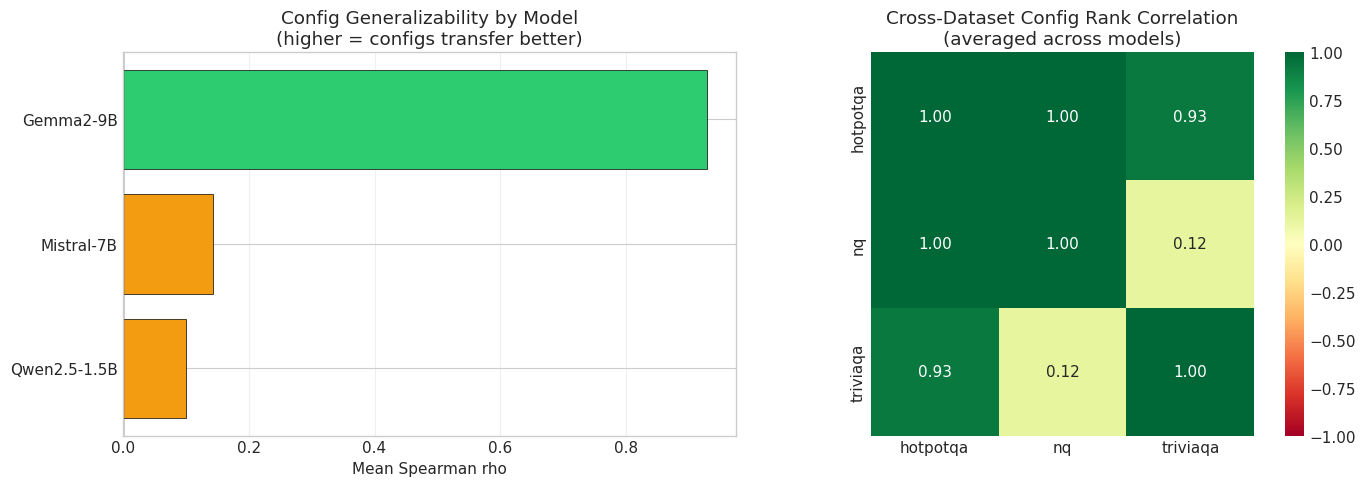



Universal vs Specialist Configurations:


In [13]:
# Cross-dataset generalization: do configs that rank well on one dataset rank well on others?
datasets = sorted(rag['dataset'].unique())

if len(datasets) >= 2:
    # Build a config fingerprint for matching configs across datasets
    config_cols_gen = ['retriever_type', 'embedding_model', 'reranker', 'prompt',
                       'query_transform', 'top_k', 'agent_type']
    config_cols_gen = [c for c in config_cols_gen if c in rag.columns]

    # Create config key (string hash of component values)
    rag_gen = rag.copy()
    rag_gen['config_key'] = rag_gen[config_cols_gen].astype(str).agg('|'.join, axis=1)

    # For each model, compute per-config mean F1 within each dataset
    # Then correlate ranks across datasets
    print("Cross-Dataset Rank Correlation (Spearman rho)")
    print("=" * 60)
    print("For each model, rank all configs by F1 on dataset A, then check")
    print("if those ranks predict performance on dataset B.\n")

    all_rhos = []
    for model in sorted(rag_gen['model_short'].unique()):
        m_df = rag_gen[rag_gen['model_short'] == model]
        ds_scores = {}
        for ds in datasets:
            ds_df = m_df[m_df['dataset'] == ds]
            if len(ds_df) < 5:
                continue
            # Mean F1 per config on this dataset
            means = ds_df.groupby('config_key')[PRIMARY_METRIC].mean()
            ds_scores[ds] = means

        if len(ds_scores) < 2:
            continue

        # Pairwise Spearman correlations between datasets
        from itertools import combinations as combs
        for ds_a, ds_b in combs(sorted(ds_scores.keys()), 2):
            # Align on shared configs
            shared = ds_scores[ds_a].index.intersection(ds_scores[ds_b].index)
            if len(shared) < 5:
                continue
            rho, p = scipy_stats.spearmanr(ds_scores[ds_a].loc[shared],
                                           ds_scores[ds_b].loc[shared])
            all_rhos.append({
                'model': model, 'dataset_a': ds_a, 'dataset_b': ds_b,
                'rho': rho, 'p_value': p, 'n_shared': len(shared),
            })
            sig = '*' if p < 0.05 else ''
            print(f"  {model:<16s} {ds_a} ↔ {ds_b}: rho={rho:+.3f} "
                  f"(p={p:.3f}{sig}, n={len(shared)} shared configs)")

    rho_df = pd.DataFrame(all_rhos)

    if not rho_df.empty:
        # Summary: overall generalizability
        mean_rho = rho_df['rho'].mean()
        median_rho = rho_df['rho'].median()
        n_sig = (rho_df['p_value'] < 0.05).sum()
        n_pos = (rho_df['rho'] > 0).sum()
        print(f"\nOverall generalizability:")
        print(f"  Mean rho:   {mean_rho:+.3f}")
        print(f"  Median rho: {median_rho:+.3f}")
        print(f"  Significant (p<.05): {n_sig}/{len(rho_df)}")
        print(f"  Positive:   {n_pos}/{len(rho_df)}")
        if mean_rho > 0.5:
            print("  => Configs GENERALIZE well across datasets")
        elif mean_rho > 0.2:
            print("  => MODERATE generalization — some dataset-specific tuning helps")
        else:
            print("  => WEAK generalization — dataset-specific configs needed")

        # Heatmap: per-model mean rho (averaged across dataset pairs)
        if len(rho_df['model'].unique()) > 1:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))

            # Panel 1: rho by model (bar chart)
            model_rho = rho_df.groupby('model')['rho'].mean().sort_values()
            colors = ['#2ecc71' if r > 0.3 else '#f39c12' if r > 0 else '#e74c3c'
                      for r in model_rho.values]
            ax = axes[0]
            ax.barh(range(len(model_rho)), model_rho.values, color=colors,
                    edgecolor='black', linewidth=0.5)
            ax.set_yticks(range(len(model_rho)))
            ax.set_yticklabels(model_rho.index)
            ax.axvline(x=0, color='black', lw=1)
            ax.set_xlabel('Mean Spearman rho')
            ax.set_title('Config Generalizability by Model\n(higher = configs transfer better)')
            ax.grid(axis='x', alpha=0.3)

            # Panel 2: heatmap of rho per dataset pair, averaged across models
            pair_rho = rho_df.groupby(['dataset_a', 'dataset_b'])['rho'].mean()
            # Build symmetric matrix
            ds_list = sorted(set(rho_df['dataset_a']) | set(rho_df['dataset_b']))
            rho_matrix = pd.DataFrame(1.0, index=ds_list, columns=ds_list)
            for (da, db), r in pair_rho.items():
                rho_matrix.loc[da, db] = r
                rho_matrix.loc[db, da] = r
            ax2 = axes[1]
            sns.heatmap(rho_matrix, annot=True, fmt='.2f', cmap='RdYlGn',
                        vmin=-1, vmax=1, ax=ax2, square=True)
            ax2.set_title('Cross-Dataset Config Rank Correlation\n(averaged across models)')

            plt.tight_layout()
            plt.show()

    # Identify "universal" vs "specialist" configs
    print("\n\nUniversal vs Specialist Configurations:")
    print("=" * 60)

    # For each config that appears on all datasets, compute per-dataset percentile
    for model in sorted(rag_gen['model_short'].unique()):
        m_df = rag_gen[rag_gen['model_short'] == model]
        ds_pcts = {}
        for ds in datasets:
            ds_df = m_df[m_df['dataset'] == ds]
            if len(ds_df) < 5:
                continue
            means = ds_df.groupby('config_key')[PRIMARY_METRIC].mean()
            # Convert to percentile ranks
            pcts = means.rank(pct=True)
            ds_pcts[ds] = pcts

        if len(ds_pcts) < 2:
            continue

        # Find configs present in all datasets
        shared_keys = set.intersection(*[set(p.index) for p in ds_pcts.values()])
        if len(shared_keys) < 3:
            continue

        # Build percentile matrix
        pct_df = pd.DataFrame({ds: pcts.loc[list(shared_keys)]
                               for ds, pcts in ds_pcts.items()})
        pct_df['min_pct'] = pct_df.min(axis=1)
        pct_df['mean_pct'] = pct_df.mean(axis=1)
        pct_df['spread'] = pct_df[datasets[:len(ds_pcts)]].max(axis=1) - pct_df[datasets[:len(ds_pcts)]].min(axis=1)

        # Universal: high min_pct (good everywhere)
        universal = pct_df.nlargest(3, 'min_pct')
        # Specialist: high spread (great on one, poor on another)
        specialist = pct_df.nlargest(3, 'spread')

        if not universal.empty:
            print(f"\n  {model} — Top Universal Configs (high everywhere):")
            for cfg_key, row in universal.iterrows():
                # Decode config key
                parts = cfg_key.split('|')
                short = '/'.join(str(p) for p in parts[:4])
                ds_str = ', '.join(f"{ds}={row.get(ds, 0):.0%}" for ds in datasets if ds in row)
                print(f"    [{short}...] {ds_str}  (min={row['min_pct']:.0%})")

        if not specialist.empty and specialist['spread'].max() > 0.3:
            print(f"  {model} — Top Specialist Configs (dataset-dependent):")
            for cfg_key, row in specialist.iterrows():
                parts = cfg_key.split('|')
                short = '/'.join(str(p) for p in parts[:4])
                ds_str = ', '.join(f"{ds}={row.get(ds, 0):.0%}" for ds in datasets if ds in row)
                print(f"    [{short}...] {ds_str}  (spread={row['spread']:.0%})")
else:
    print("Only 1 dataset found — cross-dataset analysis requires >= 2 datasets.")

## 7. Summary

Key takeaways:
- Which factor explains the most variance
- Best prompt strategy
- Optimal top-K range
- Synergistic and redundant combinations
- Universal vs dataset-specific configurations